# Install required packages

In [1]:
!pip install python-binance
!pip install catboost
!pip install matplotlib --upgrade
!pip install mpl_finance

     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 501kB 12.4MB/s 
     |████████████████████████████████| 3.2MB 17.1MB/s 
     |████████████████████████████████| 3.1MB 48.9MB/s 
     |████████████████████████████████| 184kB 54.9MB/s 
     |████████████████████████████████| 286kB 49.9MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
     |████████████████████████████████| 256kB 52.2MB/s 
     |████████████████████████████████| 67.3MB 76kB/s 
     |████████████████████████████████| 10.3MB 9.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [2]:
import pandas as pd
import numpy as np

import time
import dateparser
import pytz
import json

import math  

import datetime as dt
from datetime import datetime, timedelta

from threading import Thread

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates

from mpl_finance import candlestick_ochl



from sklearn import preprocessing, model_selection, neighbors, svm
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv

from tqdm import tqdm as tqdm

from binance.client import Client

# Define Financial Indicators


In [26]:
df

index      Open      High  ...          MA_3         EMA_3  Momentum_3
0        0   6244.33   6608.59  ...           NaN           NaN         NaN
1        1   6558.96   6690.00  ...           NaN           NaN         NaN
2        2   6590.90   6699.28  ...           NaN           NaN         NaN
3        3   6568.18   6950.00  ...   6575.303333   6580.155714         NaN
4        4   6942.65   7352.71  ...   6690.443333   6758.286000      345.42
..     ...       ...       ...  ...           ...           ...         ...
471    471  50594.45  50868.53  ...  51602.260000  51259.170098    -2048.09
472    472  47226.24  48215.02  ...  49727.156667  49247.985049    -5625.31
473    473  46358.26  47543.85  ...  48063.163333  47803.117525    -4991.98
474    474  47015.81  47254.98  ...  46870.286667  47409.463762    -3578.63
475    475  44791.57  46056.69  ...  46055.210000  46100.516881    -2445.23

[476 rows x 11 columns]

In [207]:
def moving_average(df, n):
  MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
  MA = pd.DataFrame(MA)
  MA = pd.concat([MA.loc[1], MA])
  MA = MA.reset_index()
  MA = MA.drop([0,'index'], axis=1)
  df = df.join(MA)
  return df

In [208]:
def exponential_moving_average(df, n):
  EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name="EMA_" + str(n))
  EMA = pd.DataFrame(EMA)
  EMA = pd.concat([EMA.loc[1], EMA])
  EMA = EMA.reset_index()
  EMA = EMA.drop([0,'index'], axis=1)
  df = df.join(EMA)
  return df

In [209]:
def momentum(df, n):
  M = pd.Series(df['Close'].diff(n), name="Momentum_"+str(n))
  M = pd.DataFrame(M)
  M = pd.concat([M.loc[1], M])
  M = M.reset_index()
  M = M.drop([0,'index'], axis=1)
  df = df.join(M)
  return df

In [210]:
def bollinger_bands(df, n):
  MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean())
  MSD = pd.Series(df['Close'].rolling(n, min_periods=n).std())
  b1 = 4 * MSD / MA
  B1 = pd.Series(b1, name = "BollingerB_" + str(n))
  B1 = pd.DataFrame(B1)
  B1 = pd.concat([B1.loc[1], B1])
  B1 = B1.reset_index()
  B1 = B1.drop([0,'index'], axis=1)
  df = df.join(B1)
  b2 = (df['Close'] - MA  + 2 * MSD) / (4 * MSD)
  B2 = pd.Series(b2, name='Bollinger%b_'+str(n))
  B2 = pd.DataFrame(B2)
  B2 = pd.concat([B2.loc[1], B2])
  B2 = B2.reset_index()
  B2 = B2.drop([0,'index'], axis=1)
  df = df.join(B2)
  return df

In [211]:
def stochastic_oscillator(df ,n):
  S0K = pd.Series((df['Close']- df['Low']) / (df['High']-df['Low']), name='S0k_' + str(n))
  S0K = pd.DataFrame(S0K)
  S0K = pd.concat([S0K.loc[1], S0K])
  S0K = S0K.reset_index()
  S0K = S0K.drop([0,'index'], axis=1)
  df = df.join(S0K)
  return df

In [212]:
def relative_strength_index(df, n):
  i = 0
  UpI = [0]
  DoI = [0]

  while i + 1 <= df.index[-1]:
    UpMove = df.loc[i+1, 'High'] - df.loc[i, 'High']
    DoMove = df.loc[i+1, 'Low'] - df.loc[i, 'Low']
    if UpMove > DoMove and UpMove > 0:
      UpD = UpMove
    else:
      UpD = 0
    UpI.append(UpD)
    if DoMove > UpMove and DoMove > 0:
      DoD = DoMove
    else:
      DoD = 0
    DoI.append(DoD)
    i = i + 1

  UpI = pd.Series(UpI)
  DoI = pd.Series(DoI)
  PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
  NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
  RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
  RSI = pd.DataFrame(RSI)
  RSI = pd.concat([RSI.loc[1], RSI])
  RSI = RSI.reset_index()
  RSI = RSI.drop([0,'index'], axis=1)
  df = df.join(RSI)
  return df

In [213]:
def common_channel_index(df, n):
  PP = (df['High'] + df['Low'] + df['Close']) / 3
  CCI = pd.Series((PP - PP.rolling(n, min_periods=n).mean()) / PP.rolling(n, min_periods=n).std(), name='CCI_' + str(n))
  CCI = pd.DataFrame(CCI)
  CCI = pd.concat([CCI.loc[1], CCI])
  CCI = CCI.reset_index()
  CCI = CCI.drop([0,'index'], axis=1)
  df = df.join(CCI)
  return df

In [214]:
def standart_deviation(df, n):
  hola = pd.Series(df['Close'].rolling(n, min_periods=n).std(), name='STD_' + str(n))
  hola = pd.DataFrame(hola)
  hola = pd.concat([hola.loc[1], hola])
  hola = hola.reset_index()
  hola = hola.drop([0,'index'], axis=1)
  df.join(hola)
  return df

# Define Binance Helper Functions

In [215]:
def binanceDataFrame(klines):
  df = pd.DataFrame(klines.reshape(-1,12), dtype=float, columns=['Open Time',
                                                                 'Open',
                                                                 'High',
                                                                 'Low',
                                                                 'Close',
                                                                 'Volume',
                                                                 'Close Time',
                                                                 'Quote asset volume',
                                                                 'Number of trades',
                                                                 'Taker buy base asset volume',
                                                                 'Taker buy quote asset volume',
                                                                 'Can be ignored']);

  df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
  df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')

  return df

In [216]:
def date_to_miliseconds(date_str):
  epoch = datetime.utcfromtimestamp(0).replace(tzinfo=pytz.utc)
  d = dateparser.parse(date_str)
  if d.tzinfo is None or d.tzinfo.utcoffset(d) is None:
    d = d.replace(tzinfo=pytz.utc)

  #return difference in time
  return int((d - epoch).total_seconds()*1000.0)

In [217]:
def interval_to_miliseconds(interval):
  ms = None
  seconds_per_unit = {
      "m": 60,
      "h": 60 * 60,
      "d": 24 * 60 * 60,
      "w": 7 * 24 * 60 * 60,
  }

  unit = interval[-1]
  if unit in seconds_per_unit:
    try:
      ms = int(interval[:-1]) * seconds_per_unit[unit] * 1000
    except:
      pass

  return ms

In [218]:
def get_historical_klines(symbol, interval, start_str, end_str=None):
  output_data=[]
  limit=500
  timeFrame = interval_to_miliseconds(interval)
  start_ts = date_to_miliseconds(start_str)
  end_ts = None
  if end_str:
    end_ts = date_to_miliseconds(end_str)
  
  idx = 0
  symbol_existed = False
  while True:
    #fetch
    temp_data = client.get_klines(symbol = symbol, 
                                  interval = interval, 
                                  limit = limit, 
                                  startTime = start_ts, 
                                  endTime = end_ts)
    
    if not symbol_existed and len(temp_data):
      symbol_existed = True

    if symbol_existed:
      output_data += temp_data

      start_ts = temp_data[len(temp_data) - 1][0] + timeFrame

    idx += 1

    if len(temp_data)<limit:
      break

    if idx % 3 == 0:
      time.sleep(1)

  return output_data

# Construct Binance Client

In [219]:
api_key = ''
api_secret = ''
client = Client(api_key, api_secret)

# Get Market Depth

In [220]:
depth = client.get_order_book(symbol = 'BTCEUR')

In [221]:
depth

{'asks': [['43436.23000000', '0.17696100'],
  ['43436.24000000', '0.03304400'],
  ['43436.35000000', '0.01783500'],
  ['43441.85000000', '0.06067900'],
  ['43447.35000000', '0.01815600'],
  ['43454.57000000', '0.07138000'],
  ['43454.58000000', '0.27860600'],
  ['43454.60000000', '0.06129800'],
  ['43458.22000000', '0.07085600'],
  ['43459.83000000', '0.19600000'],
  ['43461.85000000', '0.01634500'],
  ['43466.66000000', '0.04188500'],
  ['43469.69000000', '0.20400000'],
  ['43471.19000000', '0.06875600'],
  ['43471.46000000', '0.05968200'],
  ['43473.48000000', '0.05019300'],
  ['43474.36000000', '0.97070300'],
  ['43476.25000000', '0.22816800'],
  ['43476.26000000', '0.07052900'],
  ['43478.06000000', '0.00598900'],
  ['43486.43000000', '0.12677300'],
  ['43496.60000000', '0.07885000'],
  ['43500.00000000', '0.01506000'],
  ['43500.28000000', '0.22998400'],
  ['43501.23000000', '0.20000000'],
  ['43502.01000000', '0.11170900'],
  ['43505.70000000', '0.15000000'],
  ['43506.21000000',

# Get BTCEUR 1DAY from Binance

In [222]:
%%time
symbol = "BTCEUR"
start = "1 Jan, 2020"
interval = Client.KLINE_INTERVAL_1DAY
klines = get_historical_klines(symbol,interval,start)
klines = np.array(klines)
df = binanceDataFrame(klines)

CPU times: user 19.3 ms, sys: 0 ns, total: 19.3 ms
Wall time: 125 ms


In [223]:
df

Open Time      Open  ...  Taker buy quote asset volume  Can be ignored
0   2020-01-03   6244.33  ...                  1.196953e+04             0.0
1   2020-01-04   6558.96  ...                  9.870789e+03             0.0
2   2020-01-05   6590.90  ...                  1.432118e+04             0.0
3   2020-01-06   6568.18  ...                  4.381985e+04             0.0
4   2020-01-07   6942.65  ...                  1.811621e+05             0.0
..         ...       ...  ...                           ...             ...
471 2021-04-18  50594.45  ...                  1.233544e+08             0.0
472 2021-04-19  47226.24  ...                  9.018479e+07             0.0
473 2021-04-20  46358.26  ...                  9.056943e+07             0.0
474 2021-04-21  47015.81  ...                  7.756149e+07             0.0
475 2021-04-22  44791.57  ...                  9.499308e+07             0.0

[476 rows x 12 columns]

In [224]:
df2 = df

In [225]:
df.describe()

Open          High  ...  Taker buy quote asset volume  Can be ignored
count    476.000000    476.000000  ...                  4.760000e+02           476.0
mean   16722.146576  17231.563235  ...                  2.199419e+07             0.0
std    13780.532243  14239.117548  ...                  3.760725e+07             0.0
min     4368.100000   4894.470000  ...                  9.870789e+03             0.0
25%     8227.045000   8380.032500  ...                  2.989751e+05             0.0
50%     9352.265000   9510.000000  ...                  1.340985e+06             0.0
75%    19539.077500  19951.325000  ...                  3.103486e+07             0.0
max    53187.440000  54296.810000  ...                  2.520620e+08             0.0

[8 rows x 10 columns]

In [226]:
df = df.reset_index()
df.head()

index  Open Time  ...  Taker buy quote asset volume  Can be ignored
0      0 2020-01-03  ...                  11969.529894             0.0
1      1 2020-01-04  ...                   9870.788568             0.0
2      2 2020-01-05  ...                  14321.183331             0.0
3      3 2020-01-06  ...                  43819.850390             0.0
4      4 2020-01-07  ...                 181162.062088             0.0

[5 rows x 13 columns]

# Preporcessing

In [227]:
remove_cols = [c for c in df.columns if c not in ['Open','Close','High','Low','Volume','Number of trades','Quote asset volume','index']]
df.drop(remove_cols, axis=1, inplace=True)

## Calculate financial indicators for serveral windows

In [228]:
windows = [3,5,9,10]

In [229]:
for w in tqdm(windows):
  df = moving_average(df, w)
  df = exponential_moving_average(df, w)
  df = momentum(df,w)
  df = bollinger_bands(df,w)
  df = stochastic_oscillator(df,w)
  df = relative_strength_index(df,w)
  df = common_channel_index(df,w)
  df = standart_deviation(df,w)
  

100%|██████████| 4/4 [00:00<00:00, 15.29it/s]


In [87]:
df

index      Open      High  ...          MA_3         EMA_3  Momentum_3
0        0   6244.33   6608.59  ...           NaN           NaN         NaN
1        1   6558.96   6690.00  ...           NaN           NaN         NaN
2        2   6590.90   6699.28  ...           NaN           NaN         NaN
3        3   6568.18   6950.00  ...   6575.303333   6580.155714         NaN
4        4   6942.65   7352.71  ...   6690.443333   6758.286000      345.42
..     ...       ...       ...  ...           ...           ...         ...
471    471  50594.45  50868.53  ...  51602.260000  51259.170098    -2048.09
472    472  47226.24  48215.02  ...  49727.156667  49247.985049    -5625.31
473    473  46358.26  47543.85  ...  48063.163333  47803.117525    -4991.98
474    474  47015.81  47254.98  ...  46870.286667  47409.463762    -3578.63
475    475  44791.57  46056.69  ...  46055.210000  46100.516881    -2445.23

[476 rows x 11 columns]

In [74]:
#df = df.drop(['Open','High','Low'], axis=1)

In [75]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Uninstalling matplotlib-3.1.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.1.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.1.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.1.3
  Using cached https://files.pythonhosted.org/packages/4c/9b/35ab3469fd1509f7636a344940569ebfd33239673fd2318e80b4700a257c/matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


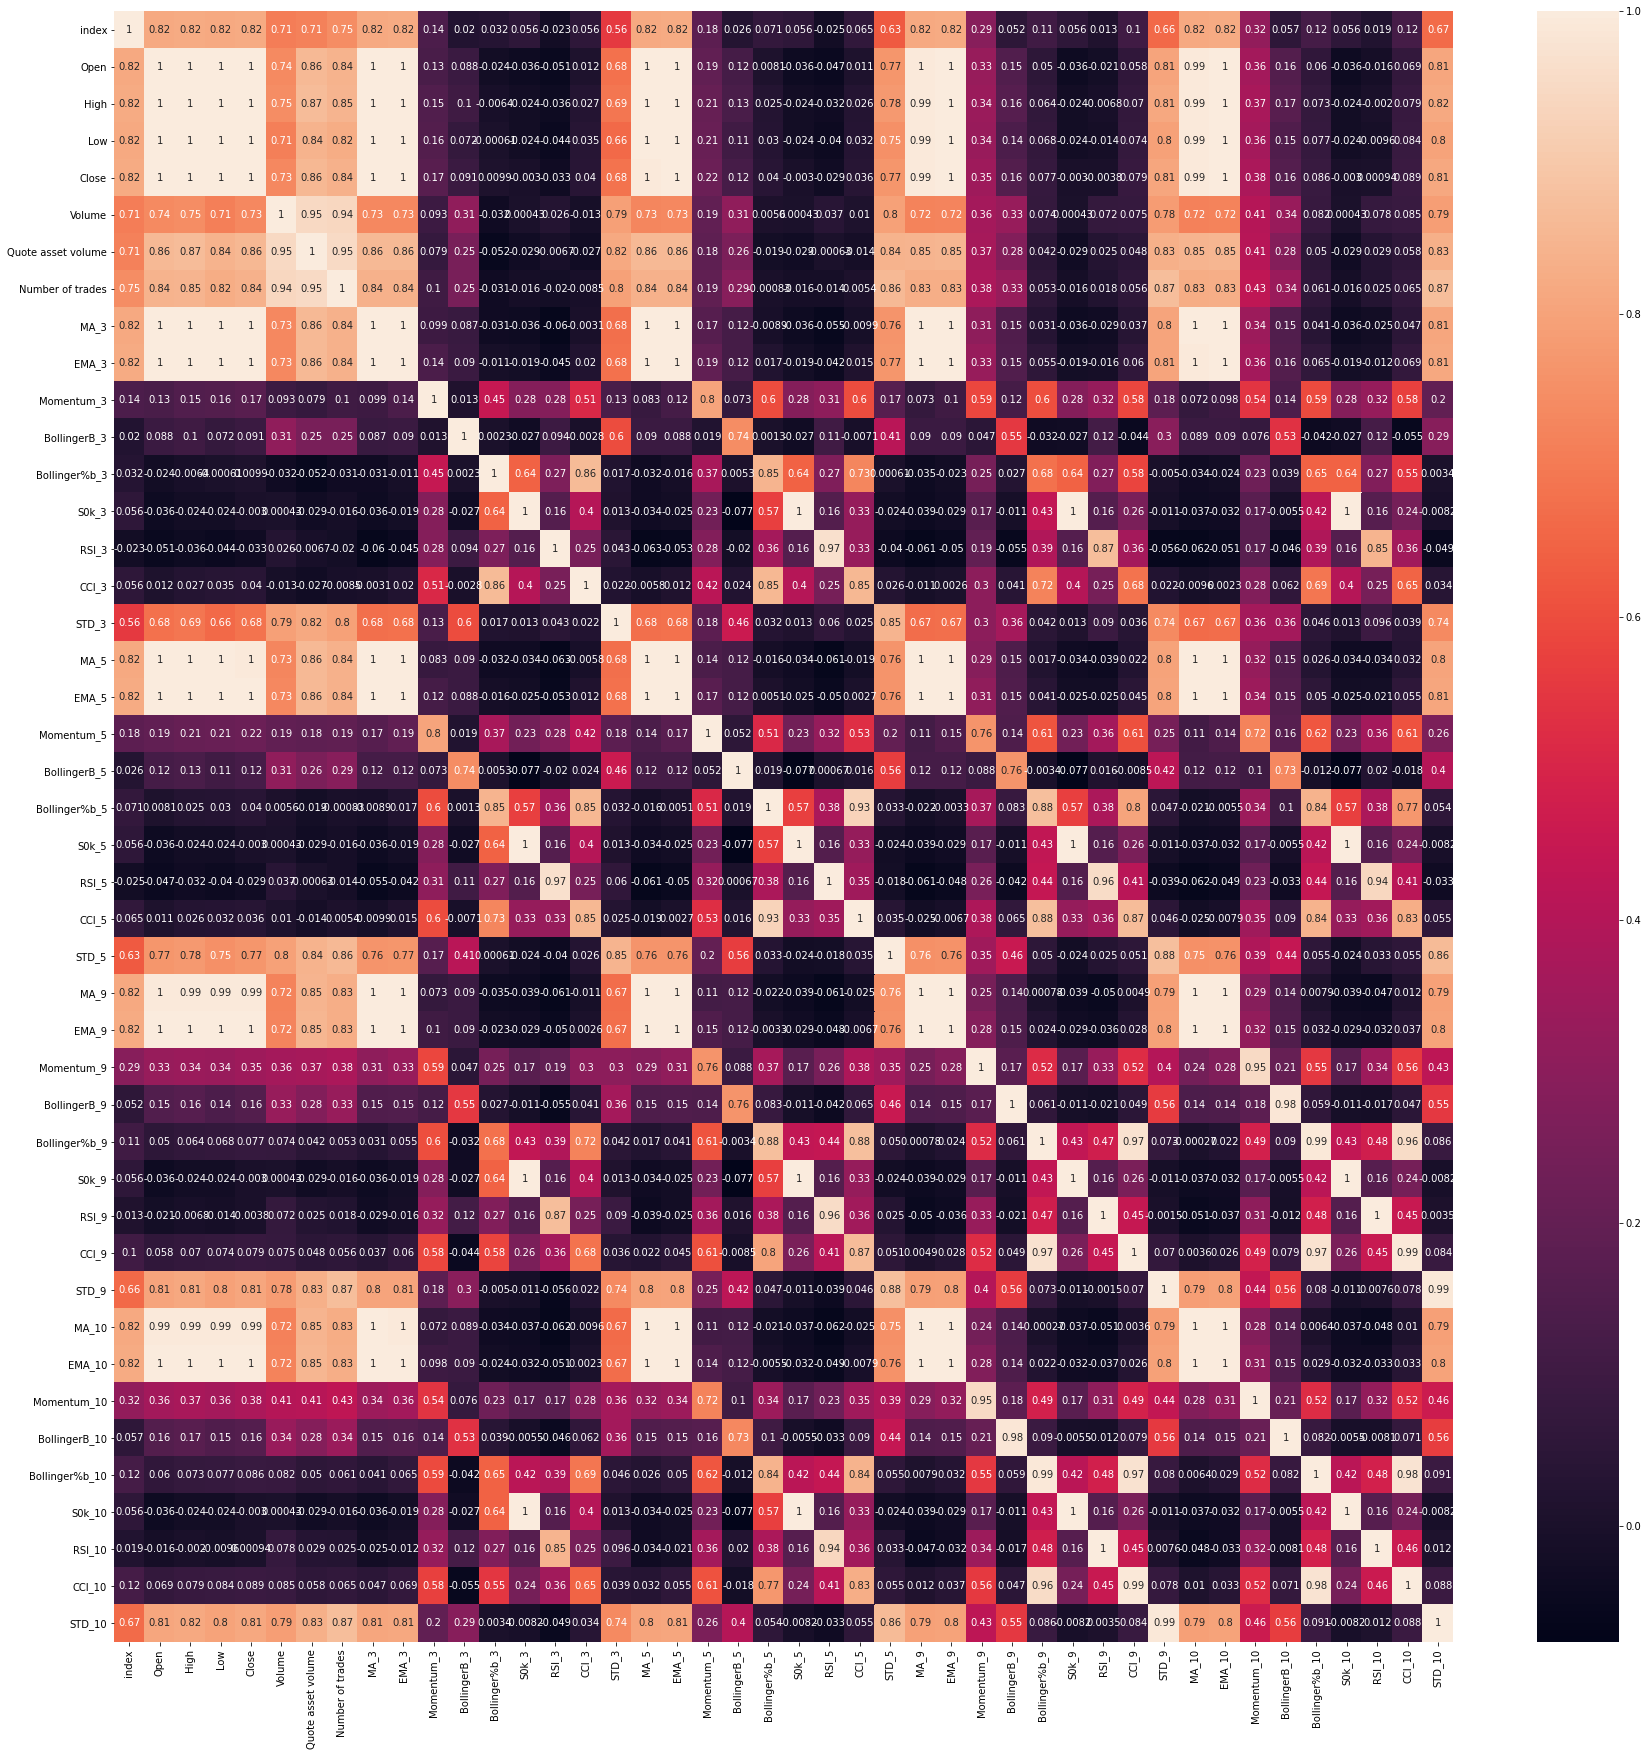

In [76]:
import seaborn as sn
import seaborn as sns
corrMatrix = df.corr()
plt.figure(figsize=(30,30))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [77]:
list(df)

['index',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Quote asset volume',
 'Number of trades',
 'MA_3',
 'EMA_3',
 'Momentum_3',
 'BollingerB_3',
 'Bollinger%b_3',
 'S0k_3',
 'RSI_3',
 'CCI_3',
 'STD_3',
 'MA_5',
 'EMA_5',
 'Momentum_5',
 'BollingerB_5',
 'Bollinger%b_5',
 'S0k_5',
 'RSI_5',
 'CCI_5',
 'STD_5',
 'MA_9',
 'EMA_9',
 'Momentum_9',
 'BollingerB_9',
 'Bollinger%b_9',
 'S0k_9',
 'RSI_9',
 'CCI_9',
 'STD_9',
 'MA_10',
 'EMA_10',
 'Momentum_10',
 'BollingerB_10',
 'Bollinger%b_10',
 'S0k_10',
 'RSI_10',
 'CCI_10',
 'STD_10']

In [78]:
df = df.drop(['Momentum_3','BollingerB_3','Bollinger%b_3','S0k_3','CCI_3','Momentum_5','BollingerB_5','Bollinger%b_5','S0k_5','CCI_5','BollingerB_9','Bollinger%b_9','S0k_9','CCI_9','BollingerB_10','Bollinger%b_10','S0k_10','CCI_10'], axis=1)

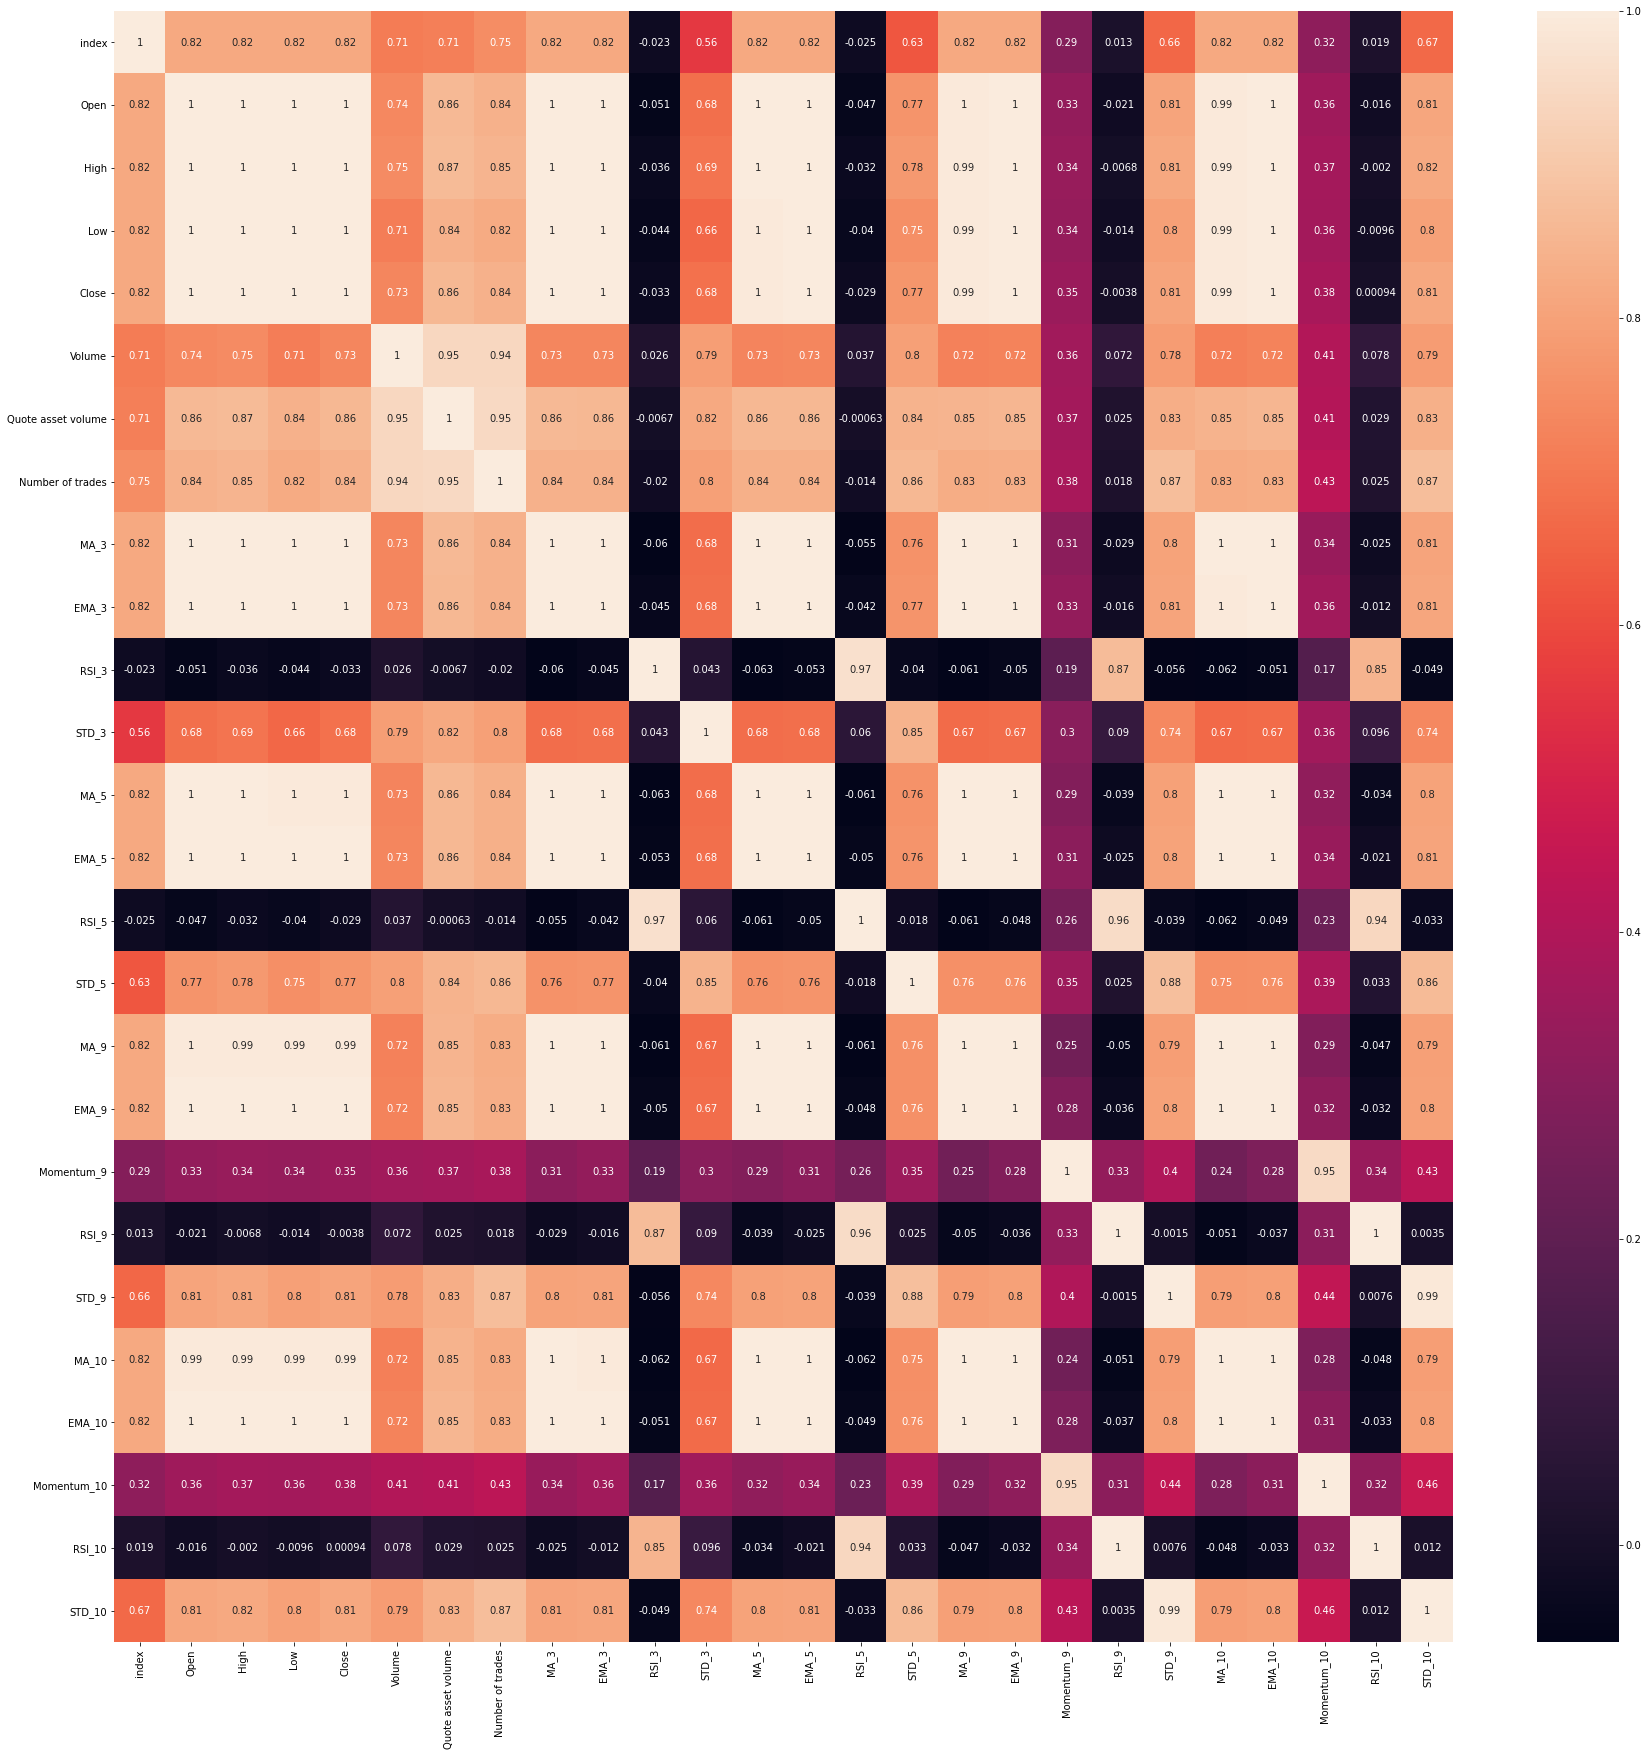

In [79]:
import seaborn as sn
import seaborn as sns
corrMatrix = df.corr()
plt.figure(figsize=(30,30))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [80]:
df.to_excel("bolsa.xlsx")

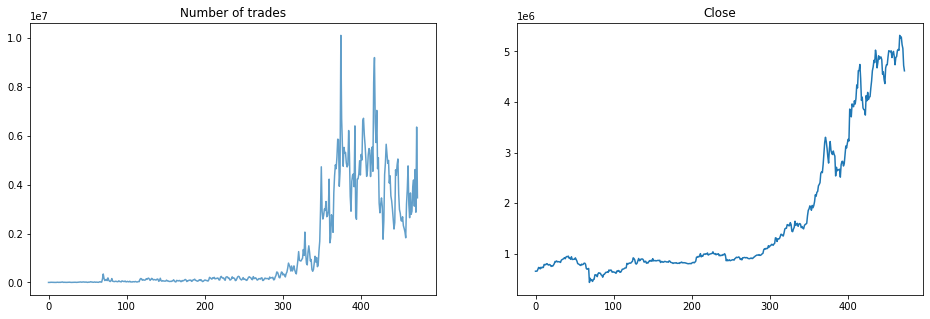

In [ ]:
f = plt.figure(figsize=(16,5))
f.add_subplot(1,2, 1)
plt.title("Number of trades")
plt.plot(df['Number of trades']*15, label='Number of trades', alpha=0.7)
f.add_subplot(1,2, 2)
plt.title("Close")
plt.plot(df['Close']*100, label='Train')
plt.show(block=True)

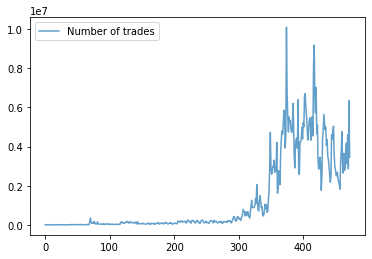

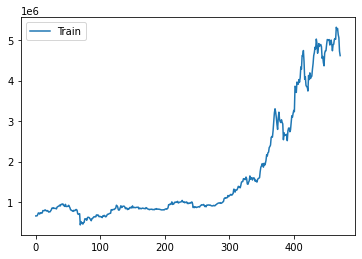

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(df['Number of trades']*15, label='Number of trades', alpha=0.7)
plt.legend(loc='best')
plt.show()
plt.figure(figsize=(6,4))
plt.plot(df['Close']*100, label='Train')
plt.legend(loc='best')
plt.show()

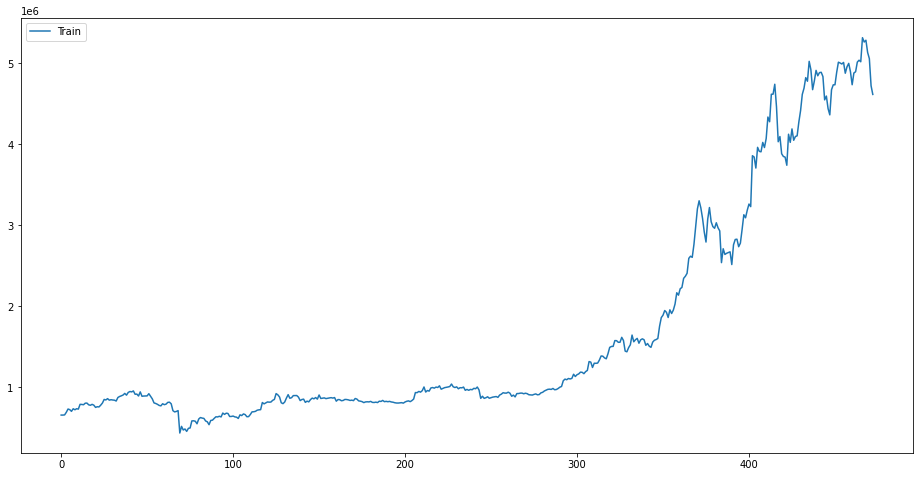

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df['Close']*100, label='Train')
plt.legend(loc='best')
plt.show()

In [ ]:
df[452:]

index     Close       Volume  ...        EMA_10  Momentum_10       STD_10
452    452  50150.08  2759.419244  ...  47610.947339      1246.12  2020.584393
453    453  50051.22  3713.653204  ...  48054.633278      1675.26  2221.367825
454    454  49929.11  2554.113170  ...  48395.447227      4430.03  2325.948256
455    455  50123.42  2109.630537  ...  48709.624095      4156.53  2401.138901
456    456  48788.28  2126.046231  ...  48723.925169      4371.79  2079.273245
457    457  49581.49  1609.655164  ...  48879.846047      5936.38  1303.710416
458    458  50006.23  2053.165360  ...  49084.643129      3255.38  1097.909132
459    459  48979.49  2848.554283  ...  49065.524379      1625.17   891.121129
460    460  47366.99  4368.289712  ...  48756.699946         5.90   889.631435
461    461  48818.22  2623.743809  ...  48767.885410       -81.87   894.977385
462    462  48970.74  2067.302452  ...  48804.768063     -1179.34   859.131133
463    463  50161.53  3017.919078  ...  49051.452052       110.31   871.023155
464    464  50394.44  1885.481822  ...  49295.631679       465.33   920.992518
465    465  50205.78  3002.212124  ...  49461.113192        82.36   929.315173
466    466  53177.79  4080.575544  ...  50136.872611      4389.51  1504.859694
467    467  52642.53  4526.906752  ...  50592.446682      3061.04  1753.826155
468    468  52862.11  2709.838848  ...  51005.112740      2855.88  1962.022837
469    469  51350.23  3901.235126  ...  51067.861333      2370.74  1919.727192
470    470  50594.44  2162.610072  ...  50981.784727      3227.45  1552.998835
471    471  47236.80  5801.605730  ...  50300.878413     -1581.42  1843.837311
472    472  46176.06  2704.652712  ...  49550.911429     -2794.68  2300.377685

[21 rows x 19 columns]

# Reducción de dimensionalidad

## PCA

In [ ]:
# Bibliotecas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

In [ ]:
df = df.dropna()

In [ ]:
df = df.astype(np.float32)

In [ ]:
df.dtypes

Close                 float32
Volume                float32
Quote asset volume    float32
Number of trades      float32
MA_3                  float32
EMA_3                 float32
STD_3                 float32
MA_5                  float32
EMA_5                 float32
STD_5                 float32
MA_9                  float32
EMA_9                 float32
Momentum_9            float32
STD_9                 float32
MA_10                 float32
EMA_10                float32
Momentum_10           float32
STD_10                float32
dtype: object

In [ ]:
df_features = df.drop(['Close'], axis=1)
df_target = df['Close']

In [ ]:
df_features = StandardScaler().fit_transform(df_features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.3, random_state=33)

In [ ]:
pca = PCA(n_components=3)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
ipca = IncrementalPCA(n_components=3,batch_size=13)
ipca.fit(X_train)

IncrementalPCA(batch_size=13, copy=True, n_components=3, whiten=False)

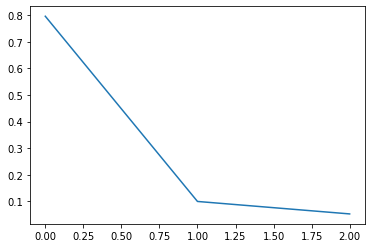

In [ ]:
plt.plot(range(len(pca.explained_variance_)), pca.explained_variance_ratio_)

In [ ]:
df_train = pca.transform(X_train)
df_test =pca.transform(X_test)

In [ ]:
from sklearn.decomposition import KernelPCA

In [ ]:
kpca_poly = KernelPCA(n_components=3, kernel='poly')
kpca_poly.fit(X_train)

In [ ]:
kpca_gauss = KernelPCA(n_components=3, kernel='rdf')
kpca_gauss.fit(X_train)

In [ ]:
plt.show()

In [ ]:
df2 = pd.DataFrame()
df2['Volume'] = df['Volume']
df2['STD_5'] = df['STD_5']
df2['RSI_5'] = df['RSI_5']
df2['Momentum_9'] = df['Momentum_9']
df2['Open'] = df['Open']
df2['MA_3'] = df['MA_3']
df2['Bollinger%b_3'] = df['Bollinger%b_3']
df2['Close'] = df['Close']


In [ ]:
df2['number_of_trades'] = df['Number of trades']

In [ ]:
corrMatrix = df2.corr()

In [ ]:
corrMatrix

Volume     STD_5  ...     Close  number_of_trades
Volume            1.000000  0.797799  ...  0.731791          0.942859
STD_5             0.797799  1.000000  ...  0.761061          0.855540
RSI_5             0.048473  0.006166  ... -0.006617          0.002606
Momentum_9        0.393548  0.409908  ...  0.405364          0.424385
Open              0.734471  0.758029  ...  0.998113          0.837155
MA_3              0.733479  0.758515  ...  0.998988          0.836825
Bollinger%b_3    -0.024148  0.016068  ...  0.023181         -0.019535
Close             0.731791  0.761061  ...  1.000000          0.835867
number_of_trades  0.942859  0.855540  ...  0.835867          1.000000

[9 rows x 9 columns]

In [ ]:
############################ Eliminar ###############################
# RSI_5 -> -0.006617
# Momentum_9 -> 0.405364	
# Bollinger%b_3	-> 0.023181
############################ Incluir ################################
# Volume -> 0.731791
# STD_5 -> 0.761061
# Open -> 0.998113
# MA_3 -> 0.998988
# number_of_trades -> 0.835867

In [ ]:
corrMatrix = df2.corr()
plt.figure(figsize=(15,15))
sn.heatmap(corrMatrix, annot=True)
plt.show()

ImportError: ignored

<Figure size 1080x1080 with 2 Axes>

In [ ]:
df.describe()

Open          High  ...     CCI_300       STD_300
count    469.000000    469.000000  ...  170.000000    170.000000
mean   16246.332367  16752.168529  ...    2.936690   6494.306587
std    13311.673804  13785.003019  ...    0.601942   4290.738716
min     4368.100000   4894.470000  ...    2.014258   1291.663567
25%     8223.070000   8365.980000  ...    2.447336   2456.553869
50%     9297.140000   9475.000000  ...    2.820138   5910.607473
75%    18622.550000  19583.610000  ...    3.400138  10185.601219
max    53187.440000  54296.810000  ...    4.833208  14649.178592

[8 rows x 86 columns]

# Test

In [ ]:
datos = pd.DataFrame()
datos['close'] = df['Close']
datos['Day Index'] = df['Open Time']

In [ ]:
# Temporalidad
datos2 = pd.DataFrame()
datos2['dayofweek'] = datos['Day Index'].dt.dayofweek
datos2['quarter'] = datos['Day Index'].dt.quarter
datos2['month'] = datos['Day Index'].dt.month
datos2['year'] = datos['Day Index'].dt.year
datos2['dayofyear'] = datos['Day Index'].dt.dayofyear
datos2['dayofmonth'] = datos['Day Index'].dt.day
datos2['weekofyear'] = datos['Day Index'].dt.weekofyear

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


In [ ]:
from sklearn.preprocessing import scale
import timeit

In [ ]:
datos_scale = pd.DataFrame(scale(datos2))
datos_scale.columns = datos2.columns

In [ ]:
X = datos_scale
y = datos['close'] 

## Train, test y val

In [ ]:
perc_values = [0.7, 0.15, 0.15];

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X

dayofweek   quarter     month      year  dayofyear  dayofmonth  weekofyear
0     0.493393 -1.052623 -1.295899 -0.544705  -1.401807   -1.435194   -1.400534
1     0.993138 -1.052623 -1.295899 -0.544705  -1.392570   -1.320708   -1.400534
2     1.492884 -1.052623 -1.295899 -0.544705  -1.383333   -1.206223   -1.400534
3    -1.505589 -1.052623 -1.295899 -0.544705  -1.374095   -1.091737   -1.336855
4    -1.005844 -1.052623 -1.295899 -0.544705  -1.364858   -0.977251   -1.336855
..         ...       ...       ...       ...        ...         ...         ...
467  -0.506098 -0.179445 -0.447151  1.835857  -0.468835   -0.175852   -0.509027
468  -0.006353 -0.179445 -0.447151  1.835857  -0.459597   -0.061366   -0.509027
469   0.493393 -0.179445 -0.447151  1.835857  -0.450360    0.053119   -0.509027
470   0.993138 -0.179445 -0.447151  1.835857  -0.441123    0.167605   -0.509027
471   1.492884 -0.179445 -0.447151  1.835857  -0.431885    0.282091   -0.509027

[472 rows x 7 columns]

In [ ]:
X_train_rand = X[:330]
y_train_rand = y[:330]
X_test_rand = X[330:401]
y_test_rand = y[330:401]
X_val_rand = X[401:]
y_val_rand = y[401:]


In [ ]:
# dimensiones de los conjuntos de train y test
n_train = int(X.shape[0] * perc_values[0])
n_val = int(X.shape[0] * perc_values[1])
n_test = int(X.shape[0] * perc_values[2])

# selección del conjunto de train
X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]

# selección del conjunto de validación
X_val = X.iloc[(n_train):(n_train+n_val)]
y_val = y.iloc[(n_train):(n_train+n_val)]

# selección del conjunto de test
X_test = X.iloc[(n_train+n_val):]
y_test = y.iloc[(n_train+n_val):]

In [ ]:
print('Train data size = ' + str(X_train_rand.shape))
print('Train target size = ' + str(y_train_rand.shape))
print('Validation data size = ' + str(X_val_rand.shape))
print('Validation target size = ' + str(y_val_rand.shape))
print('Test data size = ' + str(X_test_rand.shape))
print('Test target size = ' + str(y_test_rand.shape))

Train data size = (330, 7)
Train target size = (330,)
Validation data size = (71, 7)
Validation target size = (71,)
Test data size = (71, 7)
Test target size = (71,)


In [ ]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))
print('Test data size = ' + str(X_test.shape))
print('Test target size = ' + str(y_test.shape))

Train data size = (330, 7)
Train target size = (330,)
Validation data size = (70, 7)
Validation target size = (70,)
Test data size = (72, 7)
Test target size = (72,)


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

[17:04:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Uninstalling matplotlib-3.1.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.1.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.1.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? ERROR: Operation cancelled by user


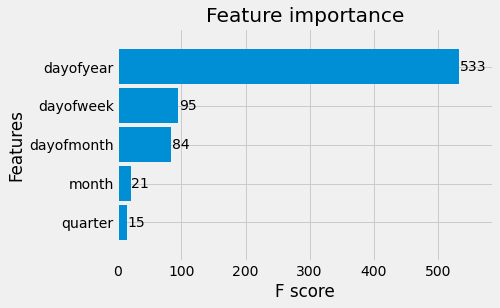

In [ ]:
plot_importance(reg, height=0.9)

### Grid_search

In [ ]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
num_boost_round = 1000

In [ ]:
reg2 = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[17:05:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-rmse:43387.3
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:41783.1
[2]	Test-rmse:40808.1
[3]	Test-rmse:40123.4
[4]	Test-rmse:39658
[5]	Test-rmse:39322
[6]	Test-rmse:39072.6
[7]	Test-rmse:38902.4
[8]	Test-rmse:38777.8
[9]	Test-rmse:38694.4
[10]	Test-rmse:38624.1
[11]	Test-rmse:38578.3
[12]	Test-rmse:38545.5
[13]	Test-rmse:38523.3
[14]	Test-rmse:38507.6
[15]	Test-rmse:38496.2
[16]	Test-rmse:38489.3
[17]	Test-rmse:38484.1
[18]	Test-rmse:38480.2
[19]	Test-rmse:38476.1
[20]	Test-rmse:38475.6
[21]	Test-rmse:38474.5
[22]	Test-rmse:38472
[23]	Test-rmse:38472.8
[24]	Test-rmse:38469.3
[25]	Test-rmse:38467.4
[26]	Test-rmse:38467
[27]	Test-rmse:38466.1
[28]	Test-rmse:38466
[29]	Test-rmse:38467.1
[30]	Test-rmse:38467
[31]	Test-rmse:38466.1
[32]	Test-rmse:38466.3
[33]	Test-rmse:38465.8
[34]	Test-rmse:38465.4
[35]	Test-rmse:38465.2
[36]	Test-

In [ ]:
print("Best MAE: {:.2f} with {} rounds".format(
                 reg2.best_score,
                 reg2.best_iteration+1))

Best MAE: 38465.16 with 37 rounds


In [ ]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=3,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

[17:05:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0      6243.072917      57.286638    6245.016439    134.879383
1      4399.675618      39.952739    4402.625326    118.844446
2      3105.490804      23.431669    3105.406575    103.087662
3      2197.299154      16.833990    2198.926351     83.267394
4      1560.400431      12.202511    1575.667399     65.663255
5      1112.165771       4.473811    1133.195313     56.067177
6       795.874084       5.859605     817.065063     34.156549
7       573.323222       5.228730     602.910258     23.553025
8       415.699493       5.172492     453.265422     11.843626
9       307.546824       4.869819     360.196106     11.396928
10      234.467016       7.012073     303.734497     12.276421
11      184.204636       8.526070     267.788264     15.299890
12      147.840953       9.563450     246.764008     16.303189
13      125.877955       9.457270     236.873322     15.889833
14      108.346970       9.675421     228.342895     16.237351
15       97.282336       9.731017     223.789480     15.910012
16       88.413129       9.295577     222.423940     16.654377
17       82.107279       8.919431     220.836761     16.739783
18       77.440005       8.738506     219.993179     17.818083
19       71.586483       9.352202     217.895116     19.604824
20       66.918529       9.455899     217.596217     20.851379
21       60.805391       8.508131     217.140360     21.338495
22       57.416395       8.643194     216.511205     21.964671
23       53.934971       7.976626     216.632019     22.562367
24       50.767201       8.047690     216.561554     22.342775
25       47.915450       7.730308     216.784526     21.811823
26       44.378778       7.672163     217.485209     21.972328
27       41.749610       6.994639     216.981323     21.862429
28       39.685405       6.086061     216.389740     21.697103
29       37.229643       6.687919     216.402273     21.420494
30       35.542573       6.088527     216.233225     21.687258
31       32.689401       4.921831     216.141485     21.340220
32       31.646447       4.873913     216.179128     21.281661
33       29.818932       4.390768     216.156199     21.210454
34       28.243794       4.049365     216.322652     21.407862
35       26.800662       3.616917     216.427180     21.206723
36       25.798119       3.562514     216.481262     21.208340
37       24.641174       3.985741     216.031677     21.362929
38       23.469144       4.386709     215.956823     20.885646
39       22.427303       3.918291     215.879639     21.036240
40       21.096979       4.324992     215.925924     20.960133
41       20.469465       4.164311     215.839716     21.283760

In [ ]:
cv_results['test-mae-mean'].min()

215.8397163333333

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [ ]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

CV with max_depth=9, min_child_weight=5
CV with max_depth=9, min_child_weight=6
CV with max_depth=9, min_child_weight=7
CV with max_depth=10, min_child_weight=5
CV with max_depth=10, min_child_weight=6
CV with max_depth=10, min_child_weight=7
CV with max_depth=11, min_child_weight=5
CV with max_depth=11, min_child_weight=6
CV with max_depth=11, min_child_weight=7


In [ ]:
# Update our parameters
params['max_depth'] = max_depth
params['min_child_weight'] = min_child_weight

In [ ]:
# Run CV
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)

[17:05:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:05:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Update best MAE
mean_mae = cv_results['test-mae-mean'].min()
boost_rounds = cv_results['test-mae-mean'].argmin()
print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
if mean_mae < min_mae:
    min_mae = mean_mae
    best_params = (max_depth,min_child_weight)

	MAE 183.7737366 for 83 rounds


In [ ]:
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

Best params: 11, 7, MAE: 183.7737366


In [ ]:
params['max_depth'] = 11
params['min_child_weight'] = 7

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [ ]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
[17:06:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 183.7737366 for 83 rounds
CV with subsample=1.0, colsample=0.9
[17:06:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:06

In [ ]:
params['subsample'] = 0.9
params['colsample_bytree'] = 1.0

In [ ]:
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,metrics={'mae'},early_stopping_rounds=10)
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CV with eta=0.3
[17:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 179.9867888 for 35 rounds

CV with eta=0.2
[17:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:06:40] WARNING: /workspace/src/objective/re

In [ ]:
params['eta'] = 0.1

In [ ]:
params['eval_metric'] = 'mae'

In [ ]:
params

{'colsample_bytree': 1.0,
 'eta': 0.1,
 'eval_metric': 'mae',
 'max_depth': 11,
 'min_child_weight': 7,
 'objective': 'reg:linear',
 'subsample': 0.9}

In [ ]:
best_model_Users = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=140
)

[17:07:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:44484.9
Will train until Test-mae hasn't improved in 140 rounds.
[1]	Test-mae:43857.8
[2]	Test-mae:43230.2
[3]	Test-mae:42665.4
[4]	Test-mae:42215.3
[5]	Test-mae:41757.9
[6]	Test-mae:41395.4
[7]	Test-mae:41066.9
[8]	Test-mae:40737.6
[9]	Test-mae:40438.1
[10]	Test-mae:40203
[11]	Test-mae:39997.3
[12]	Test-mae:39812.8
[13]	Test-mae:39639.6
[14]	Test-mae:39482.6
[15]	Test-mae:39346.6
[16]	Test-mae:39220.2
[17]	Test-mae:39107
[18]	Test-mae:39004.1
[19]	Test-mae:38909.5
[20]	Test-mae:38821.9
[21]	Test-mae:38743.1
[22]	Test-mae:38673
[23]	Test-mae:38609.3
[24]	Test-mae:38553.1
[25]	Test-mae:38501.4
[26]	Test-mae:38457
[27]	Test-mae:38416.1
[28]	Test-mae:38377.7
[29]	Test-mae:38342.6
[30]	Test-mae:38313
[31]	Test-mae:38285
[32]	Test-mae:38258.9
[33]	Test-mae:38233.3
[34]	Test-mae:38211.2
[35]	Test-mae:38192.1
[36]	Test-mae:38174
[37]	Test-mae:38157.8
[38]

In [ ]:
best_model_Users.save_model("my_model_time on page.model")

In [ ]:
dtrain2 = xgb.DMatrix(X_val)

In [ ]:
validacion = best_model_Users.predict(dtrain2)

In [ ]:
validacion_p = pd.DataFrame(validacion, columns={'validacion'})

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_val, validacion_p)
mse


237031942.45353463

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_val, validacion_p)

12059.45689732143

In [ ]:
todo1 = reg.predict(X)

In [ ]:
dtrain2 = xgb.DMatrix(X)

In [ ]:
todo2 = best_model_Users.predict(dtrain2)

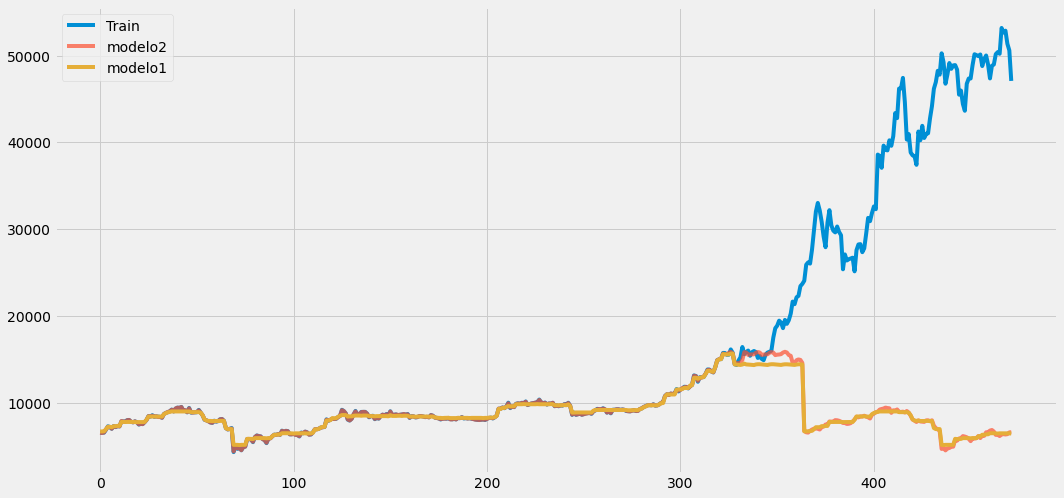

In [ ]:
plt.figure(figsize=(16,8))
#plt.plot(todo1, label='modelo1')

plt.plot(y, label='Train')
plt.plot(todo2, label='modelo2', alpha=0.7)
plt.plot(todo1, label='modelo1')
#plt.plot(todo2, label='modelo2')

plt.legend(loc='best')
plt.show()

### definición

In [ ]:
!pip install shap
!pip install eli5
!pip install lime
from collections import Counter

import shap

import eli5

import lime

from lime.lime_tabular import LimeTabularExplainer

shap.initjs()
!pip install s3fs

     |████████████████████████████████| 358kB 25.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491622 sha256=90c65d6077a912731751819c820475a8773ee7c5187881cf2f6df6f7497158e3
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 112kB 18.6MB/s 
     |████████████████████████████████| 276kB 19.1MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=dba4d0a31a32f07ef569c87671e6e1309dffbfa9ed8eda07d96fcd566cd970f3
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 112kB 40.6MB/s 
     |████████████████████████████████| 7.4MB 41.7MB/s 
     |████████████████████████████████| 1.3MB 56.1MB/s 
     |████████████████████████████████| 153kB 42.7MB/s 
     |████████████████████████████████| 143kB 57.7MB/s 
     |████████████████████████████████| 296kB 48.5MB/s 
  Created wheel for aiobotocore: filename=aiobotocore-1.3.0-cp37-none-any.whl size=45781 sha256=141e73c846ac9109b1690e3f75e29aeee7f2bd0793be0535ca0f9369f89a77b8
  Stored in directory: /root/.cache/pip/wheels/1d/5b/92/72a47210109971364c619c41e29289d4e7d58269f0cc653bf1
Successfully built aiobotocore
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urlli

In [ ]:
import time

from scipy import stats

import datetime

import s3fs

import statistics

import decimal

import matplotlib.pyplot as plt

%matplotlib inline

from IPython.display import display



import pandas as pd, numpy as np, os, random, math, matplotlib, pylab, scipy, gc



from sklearn.model_selection import train_test_split

import xgboost as xgb

from xgboost import XGBRegressor



random.seed(1)

np.random.seed(1)

import warnings

warnings.filterwarnings('ignore')

In [ ]:
# use labeled data set

shap_explainer = shap.TreeExplainer(best_model_Users)

test_shap_values = shap_explainer.shap_values(X_test)

print('Expected Value:', shap_explainer.expected_value)

pd.DataFrame(test_shap_values).head()

Expected Value: 8851.0625


0          1          2    3           4          5    6
0 -39.893536 -15.139739   2.769526  0.0    1.619870 -16.666954  0.0
1 -48.837715 -18.107506  14.767373  0.0   87.446724  47.852657  0.0
2 -40.394241 -12.612755   3.594134  0.0  117.086441  91.908997  0.0
3  18.533155  -6.653783   2.990069  0.0  311.147949  70.910568  0.0
4  59.380051  -9.602871   5.837648  0.0  338.979950  68.848419  0.0

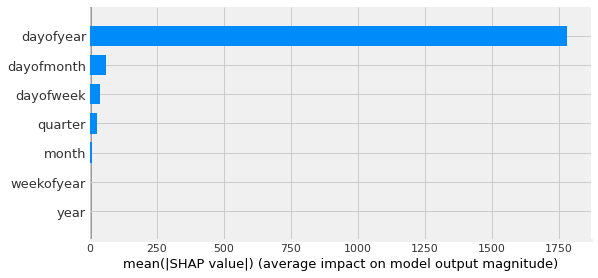

In [ ]:
shap.summary_plot(test_shap_values, X_test, plot_type="bar", max_display=30)

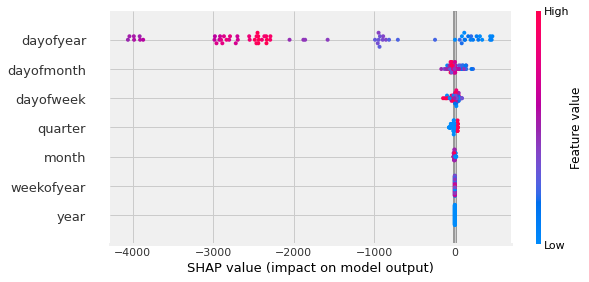

In [ ]:
# shows feature contribution

shap.summary_plot(test_shap_values, X_test, max_display=30)

## Define Train Data

In [ ]:
X = df.drop(['Close', 'High', 'Low', 'Volume'], axis=1)
y = df['Close']

## Clean Data

In [ ]:
X = X[max(windows)+1:]
y = y[max(windows)+1:]
X.fillna(value=0, inplace=True)
X.replace([np.inf, -np.inf], 0, inplace=True)

## Scaling

In [ ]:
%%time
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

CPU times: user 2.96 ms, sys: 995 µs, total: 3.95 ms
Wall time: 4.05 ms


## Split Data

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, shuffle = False)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, test_size=0.2, shuffle = True)
print("Train", X_train.shape, y_train.shape)
print("Valid", X_valid.shape, y_valid.shape)
print("Test", X_test.shape, y_test.shape)

Train (107, 82) (107,)
Valid (27, 82) (27,)
Test (34, 82) (34,)


# Train

## Catboost

### Model Definition

In [ ]:
# https://catboost.ai/docs/search/?query=catboostregressor
model = CatBoostRegressor(iterations=20_000,
                          verbose=100, 
                          # boosting_type = 'Ordered',
                          early_stopping_rounds=200,
                          loss_function = 'RMSE',
                          custom_metric = 'MAE',
                          task_type = 'CPU'
                          )

model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model = True)

Learning rate set to 0.004672
0:	learn: 10849.2920359	test: 11094.9916603	best: 11094.9916603 (0)	total: 55.7ms	remaining: 18m 34s
100:	learn: 7857.2718018	test: 8251.6082592	best: 8251.6082592 (100)	total: 769ms	remaining: 2m 31s
200:	learn: 5709.6808431	test: 6217.4597552	best: 6217.4597552 (200)	total: 1.5s	remaining: 2m 28s
300:	learn: 4197.7047238	test: 4774.3132885	best: 4774.3132885 (300)	total: 2.23s	remaining: 2m 26s
400:	learn: 3113.5006293	test: 3762.6201314	best: 3762.6201314 (400)	total: 2.97s	remaining: 2m 25s
500:	learn: 2339.2886939	test: 3021.3841699	best: 3021.3841699 (500)	total: 3.73s	remaining: 2m 25s
600:	learn: 1783.8399159	test: 2473.4635203	best: 2473.4635203 (600)	total: 4.46s	remaining: 2m 24s
700:	learn: 1384.8224362	test: 2077.6356685	best: 2077.6356685 (700)	total: 5.2s	remaining: 2m 23s
800:	learn: 1092.2493662	test: 1771.0110962	best: 1771.0110962 (800)	total: 5.93s	remaining: 2m 22s
900:	learn: 868.9091740	test: 1534.6934429	best: 1534.6934429 (900)	tot

### Hyper Parameter Tuning

In [ ]:
model_hyp = CatBoostRegressor(                          
                          early_stopping_rounds=100,
                          loss_function = 'RMSE',
                          custom_metric = 'MAE',
                          task_type = 'GPU'
                          )
grid = {
    'boosting_type': ['Ordered', 'Plain'],
    'learning_rate': [0.003, 0.006, 0.009, 0.03, 0.1, 0.5],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

In [ ]:
X_train_cv = pd.concat([X_train, X_valid])
y_train_cv = pd.concat([y_train, y_valid])
X_train_cv = X_train_cv[:360]
y_train_cv = y_train_cv[:360]

In [ ]:
print("Train", X_train_cv.shape, y_train_cv.shape)

Train (134, 82) (134,)


In [ ]:
grid_search_results = model_hyp.grid_search(grid, X_train_cv, y_train_cv, verbose=True)

Streaming output truncated to the last 5000 lines.
232:	learn: 12121.4081166	test: 14872.1330060	best: 14872.1330060 (232)	total: 2.24s	remaining: 7.38s
233:	learn: 12082.6042622	test: 14832.2700842	best: 14832.2700842 (233)	total: 2.25s	remaining: 7.38s
234:	learn: 12041.5507928	test: 14783.8787874	best: 14783.8787874 (234)	total: 2.27s	remaining: 7.38s
235:	learn: 11999.7172802	test: 14735.8458994	best: 14735.8458994 (235)	total: 2.28s	remaining: 7.39s
236:	learn: 11950.8570310	test: 14692.2288756	best: 14692.2288756 (236)	total: 2.3s	remaining: 7.39s
237:	learn: 11920.0117418	test: 14657.9154498	best: 14657.9154498 (237)	total: 2.31s	remaining: 7.4s
238:	learn: 11878.0789032	test: 14614.6503867	best: 14614.6503867 (238)	total: 2.33s	remaining: 7.43s
239:	learn: 11840.0622378	test: 14574.3135179	best: 14574.3135179 (239)	total: 2.35s	remaining: 7.44s
240:	learn: 11803.5046530	test: 14534.7245002	best: 14534.7245002 (240)	total: 2.36s	remaining: 7.44s
241:	learn: 11757.1209903	test: 1

In [ ]:
grid_search_results

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

### Use hyper parameters

In [ ]:
model1 = CatBoostRegressor(                          
    early_stopping_rounds=100,
    verbose=100, 
    boosting_type = 'Plain',
    depth =  4,
    l2_leaf_reg =  7,
    learning_rate =  0.03,
    loss_function = 'RMSE',
    custom_metric = 'MAE',
    task_type = 'GPU'
    )

model1.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model = True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 10649.4827815	test: 10895.0658217	best: 10895.0658217 (0)	total: 8.57ms	remaining: 8.57s
100:	learn: 1745.9902046	test: 2281.1979959	best: 2281.1979959 (100)	total: 486ms	remaining: 4.32s
200:	learn: 571.9824845	test: 1146.6956069	best: 1146.6956069 (200)	total: 947ms	remaining: 3.76s
300:	learn: 340.3538703	test: 911.0475046	best: 911.0475046 (300)	total: 1.36s	remaining: 3.15s
400:	learn: 262.6154041	test: 825.7236557	best: 825.7236557 (400)	total: 1.76s	remaining: 2.63s
500:	learn: 200.5753057	test: 782.1452929	best: 782.1452929 (500)	total: 2.23s	remaining: 2.23s
600:	learn: 161.3757153	test: 753.8414953	best: 753.8414953 (600)	total: 2.63s	remaining: 1.75s
700:	learn: 127.8839098	test: 741.1096285	best: 741.1096285 (700)	total: 3.1s	remaining: 1.32s
800:	learn: 108.6317087	test: 729.8251186	best: 729.6943297 (796)	total: 3.49s	remaining: 867ms
900:	learn: 91.0933138	test: 722.2326751	best: 722.2326751 (900)	total: 3.88s	remaining: 426ms
999:	learn: 73.9910010	test: 716.2

### Save and Load Models

In [ ]:
model.save_model('base_model_CPU.model')

In [ ]:
model1.save_model('hyp_model1_GPU.model')

# Test

In [ ]:
model_use = CatBoostRegressor()
model_use.load_model('hyp_model1_GPU.model')

In [ ]:
%%time
y_pred = model_use.predict(X_train)
mse_train = mean_squared_error(y_train,y_pred)
print('mean_squared_error train', math.sqrt(mse_train))
mae_train = mean_absolute_error(y_train,y_pred)
print('mean_absolute_error train', mae_train)

y_pred = model_use.predict(X_valid)
mse_valid = mean_squared_error(y_valid,y_pred)
print('mean_squared_error valid', math.sqrt(mse_valid))
mae_valid = mean_absolute_error(y_valid,y_pred)
print('mean_absolute_error valid', mae_valid)

y_pred = model_use.predict(X_test)
mse_test = mean_squared_error(y_test,y_pred)
print('mean_squared_error test', math.sqrt(mse_test))
mae_test = mean_absolute_error(y_test,y_pred)
print('mean_absolute_error test', mae_test)

mean_squared_error train 74.22837876756968
mean_absolute_error train 60.14576764885674
mean_squared_error valid 716.1750947878938
mean_absolute_error valid 476.7030793163981
mean_squared_error test 6504.01671928628
mean_absolute_error test 6163.386067811367
CPU times: user 15.7 ms, sys: 706 µs, total: 16.4 ms
Wall time: 15.4 ms


# Strategy Tester

In [ ]:
%%time 
X_test_unscaled = scaler.inverse_transform(X_test)
X_test_unscaled = pd.DataFrame(X_test_unscaled, columns=X_test.columns)

CPU times: user 1.05 ms, sys: 0 ns, total: 1.05 ms
Wall time: 914 µs


In [ ]:
X_test_unscaled['Pred_Close'] = y_pred
X_test_unscaled['Close'] = y_test.values

In [ ]:
X_test_unscaled = X_test_unscaled[['Open', 'Close', 'Pred_Close']]

In [ ]:
X_test_unscaled['Diff'] = X_test_unscaled['Close'] - X_test_unscaled['Open']
X_test_unscaled['Change'] = X_test_unscaled['Diff'] / X_test_unscaled['Open']
X_test_unscaled['Buy'] = X_test_unscaled['Pred_Close'] > X_test_unscaled['Close']

In [ ]:
# Bitcoin alınması gereken günler
X_test_unscaled[X_test_unscaled['Buy'] == True]

Empty DataFrame
Columns: [Open, Close, Pred_Close, Diff, Change, Buy]
Index: []

In [ ]:
# Bitcoin satılması gereken günler
X_test_unscaled[X_test_unscaled['Buy'] == False]

Open     Close    Pred_Close     Diff    Change    Buy
0   47800.05  50256.27  47404.682031  2456.22  0.051385  False
1   50256.27  49225.61  46232.724699 -1030.66 -0.020508  False
2   49240.70  46757.95  43744.111381 -2482.75 -0.050421  False
3   46757.97  47821.80  44528.981173  1063.83  0.022752  False
4   47834.24  49139.11  45448.977874  1304.87  0.027279  False
5   49139.11  48473.55  43633.752438  -665.56 -0.013544  False
6   48473.55  48864.73  43679.422910   391.18  0.008070  False
7   48862.06  48903.96  43658.808288    41.90  0.000858  False
8   48886.76  48375.96  42192.952546  -510.80 -0.010449  False
9   48379.72  45499.08  40459.843225 -2880.64 -0.059542  False
10  45499.08  45966.89  40901.523641   467.81  0.010282  False
11  45961.63  44416.49  39835.723276 -1545.14 -0.033618  False
12  44408.95  43645.11  39727.194148  -763.84 -0.017200  False
13  43640.52  46750.85  42415.257439  3110.33  0.071272  False
14  46736.59  47354.32  42666.062105   617.73  0.013217  False
15  47353.82  47361.09  42660.962317     7.27  0.000154  False
16  47362.20  48900.09  44085.999840  1537.89  0.032471  False
17  48924.11  50150.08  44755.669997  1225.97  0.025059  False
18  50160.29  50051.22  44297.712636  -109.07 -0.002174  False
19  50051.23  49929.11  42998.192838  -122.12 -0.002440  False
20  49926.22  50123.42  43246.725521   197.20  0.003950  False
21  50123.41  48788.28  41095.648429 -1335.13 -0.026637  False
22  48788.28  49581.49  41969.134998   793.21  0.016258  False
23  49577.65  50006.23  42367.809826   428.58  0.008645  False
24  50006.22  48979.49  40252.876890 -1026.73 -0.020532  False
25  48977.81  47366.99  39839.171493 -1610.82 -0.032889  False
26  47367.48  48818.22  40942.244154  1450.74  0.030627  False
27  48817.12  48970.74  40283.767497   153.62  0.003147  False
28  48970.74  50161.53  41839.300440  1190.79  0.024316  False
29  50175.89  50394.44  41850.837212   218.55  0.004356  False
30  50389.37  50205.78  40437.598041  -183.59 -0.003643  False
31  50205.78  53177.79  43659.281823  2972.01  0.059197  False
32  53187.44  52642.53  43381.992250  -544.91 -0.010245  False
33  52635.25  53181.60  44191.730317   546.35  0.010380  False

## Plot Accuracy

In [ ]:
#https://matplotlib.org/

figure(num=None, figsize = (12, 10), dpi=80, facecolor='silver', edgecolor='gray')

plt.subplot(2, 1, 1)
plt.plot(X_test_unscaled[['Close','Pred_Close']])
plt.xlabel('time (d1)')
plt.ylabel('$')
plt.legend(['Close', 'Prediction'])
plt.title('Close vs Predicted Close')
plt.grid(True)

plt.tight_layout()
plt.show()

ImportError: ignored

<Figure size 960x800 with 1 Axes>

## Simulation

In [ ]:
Init_Balance = 10_000
Ratio = 1
Balance = Init_Balance
BalanceGraph = []
last_order = False
SellCount = 0
BuyCount = 0
AccurateMove = 0
GrossLoss = 0
GrossGain = 0
CommisionRatio = 0
Commision = 0 

In [ ]:
%%time
for index, row in tqdm(X_test_unscaled.iterrows()):
  buy = row.Buy
  change = row.Change

  if (buy):
    Balance += change * Balance * Ratio
    BuyCount += 1
    if (change > 0):
      AccurateMove += 1
      GrossGain += abs(change * Balance * Ratio)
    else:
      GrossLoss += abs(change * Balance * Ratio)
  else:
    Balance += -change * Balance * Ratio
    SellCount += 1
    if (change < 0):
      AccurateMove += 1
      GrossGain += abs(change * Balance * Ratio)
    else:
      GrossLoss += abs(change * Balance * Ratio)

  if (last_order != buy):
    Balance -= CommisionRatio * abs(change * Balance * Ratio)
    Commision += CommisionRatio * abs(change * Balance * Ratio)

  last_order = buy

  BalanceGraph.append(Balance)

34it [00:00, 8496.56it/s]

CPU times: user 9.65 ms, sys: 0 ns, total: 9.65 ms
Wall time: 11 ms


In [ ]:
print("Balance", Balance)
print(f"Sell:{round(SellCount)}, Buy:{round(BuyCount)}, Sell Ratio: {(SellCount / (SellCount + BuyCount))}, Buy Ratio: {(BuyCount / (SellCount + BuyCount))}")
print(f"Accuracy: {AccurateMove / (SellCount + BuyCount)}")
print(f"Gross Loss:{round(GrossLoss)}, GrossGain:{round(GrossGain)}")

Balance 8750.038038598472
Sell:34, Buy:0, Sell Ratio: 1.0, Buy Ratio: 0.0
Accuracy: 0.4117647058823529
Gross Loss:4034, GrossGain:3054


In [ ]:
figure(num=None, figsize = (12, 8), dpi=80, facecolor='silver', edgecolor='gray')

plt.subplot(2, 1, 1)
plt.plot(X_test_unscaled[['Close','Pred_Close']])
plt.xlabel('time (d1)')
plt.ylabel('$')
plt.legend(['Close', 'Prediction'])
plt.title('Close vs Predicted Close')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(BalanceGraph)
plt.xlabel('time (d1)')
plt.ylabel('$')
plt.legend(['Balance'])
plt.title('Balance')
plt.grid(True)

plt.tight_layout()
plt.show()

ImportError: ignored

<Figure size 960x640 with 2 Axes>